----

# Decomposing Time Series 

In [1]:
%cd ../

c:\Users\dioni\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from IPython.display import display, HTML
import missingno as msno
import statsmodels.api as sm

np.random.seed()
tqdm.pandas()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.makedirs("imgs/chapter_3", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
assert preprocessed.is_dir(), "You have to run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02 before running this notebook"

In [5]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=660,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

-----

# Generate Charts for Trend and Seasonality

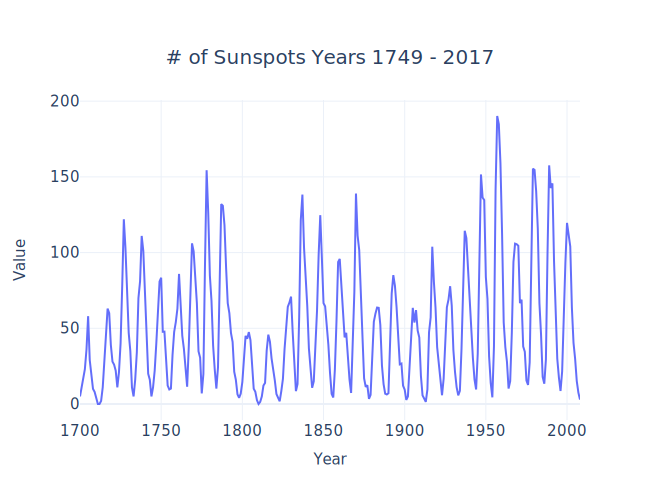

In [6]:
df = sm.datasets.sunspots.load_pandas().data
fig=px.line(df, x="YEAR", y="SUNACTIVITY", title="# of Sunspots Years 1749 - 2017")
fig = format_plot(fig, xlabel="Year")
fig.write_image("imgs/chapter_3/sunspots.png")
fig.show(renderer="svg")

In [7]:
df = pd.DataFrame({"x": np.arange(13)})

for i in range(1,4):
    df[f'Fourier Cosine Term {i}'] = np.cos((2 * np.pi * df.x * i) / 12)
    df[f'Fourier Sine Term {i}'] = np.sin((2 * np.pi * df.x * i) / 12)

df = pd.melt(df, id_vars="x",var_name="Fourier Terms")

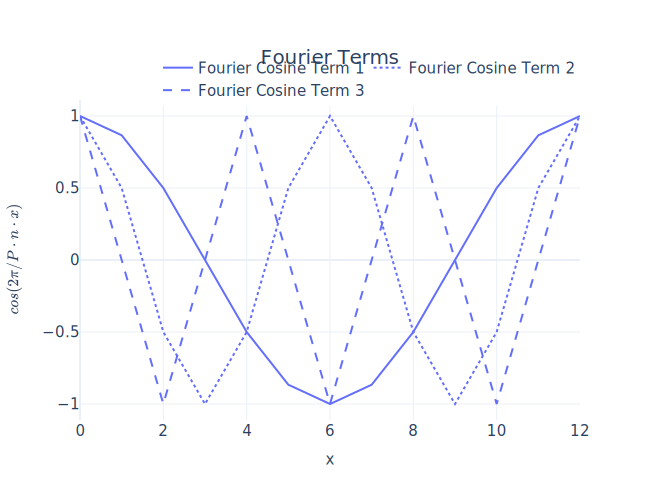

In [8]:
fig = px.line(df[df['Fourier Terms'].str.contains("Cosine")], x="x", y="value", line_dash="Fourier Terms", title="Fourier Terms")
fig = format_plot(fig, xlabel="x", ylabel="$cos(2\pi/P \cdot n \cdot x)$")
fig.write_image("imgs/chapter_3/fourier_terms.png")
fig.show(renderer="svg")


----

# Implementations

There are four impletementations that will cover here in the following subsections

## _''seasonal-decompose from statsmodel''_ 

´statsmodels.tsa.seasonal´ has a function called `seasonal_decompose`. This is an implementation that uses moving averages for the trend component and period-adjusted avarages for seasonal component. It supports both additive and multiplicative modes of decomposition. However, it doesn't tolerate missing values. Let's how we can use it.


In [9]:
# Does not support missing values, so using imputed ts instead

from src.utils.data_utils import compact_to_expanded
try:
    block_df = pd.read_parquet(preprocessed/"london_smart_meters_merged_block_0-7.parquet")
    display(block_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

c:\Users\dioni\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python\src\utils\data_utils.py:6: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


Let's take all the consumers in one block for our exercise. Keep in mind, you can do the same with more number of blocks as long as it fits in your RAM

In [10]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_5"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.sample(3)

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
5732,2012-05-19 10:00:00,MAC004925,0.087,30min,36912,Std,ACORN-C,Affluent,block_5,NO_HOLIDAY,...,267,14.63,8.93,1009.83,14.63,2.11,rain,partly-cloudy-day,0.69,Mostly Cloudy
1476,2012-02-26 18:00:00,MAC004989,0.036,30min,36624,Std,ACORN-C,Affluent,block_5,NO_HOLIDAY,...,223,10.47,4.31,1028.10,10.47,1.48,rain,partly-cloudy-night,0.66,Partly Cloudy
18153,2013-05-24 04:30:00,MAC002797,0.063,30min,31584,ToU,ACORN-C,Affluent,block_5,NO_HOLIDAY,...,269,5.84,2.59,1009.94,2.77,4.22,rain,clear-night,0.80,Clear


Taking a singe time series from the block

In [11]:
ts_df = exp_block_df[exp_block_df.LCLid=="MAC003642"].set_index("timestamp")

In [12]:
from src.imputation.interpolation import SeasonalInterpolation
ts = SeasonalInterpolation(seasonal_period=48*7).fit_transform(ts_df.energy_consumption.values.reshape(-1,1)).squeeze()

In [13]:
ts_df.head(2)

,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,,,,,,,,,,
2012-10-13 00:00:00,MAC003642,0.222,30min,24144,Std,ACORN-C,Affluent,block_5,NO_HOLIDAY,13.08,186,8.78,6.28,1007.7,7.55,2.28,rain,clear-night,0.84,Clear
2012-10-13 00:30:00,MAC003642,0.123,30min,24144,Std,ACORN-C,Affluent,block_5,NO_HOLIDAY,13.08,186,8.78,6.28,1007.7,7.55,2.28,rain,clear-night,0.84,Clear


## Seasonal Decomposition

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from src.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition

In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def decomposition_plot(
        ts_index, observed=None, seasonal=None, trend=None, resid=None
    ):
        """Plots the decomposition output
        """
        series = []
        if observed is not None:
            series += ["Original"]
        if trend is not None:
            series += ["Trend"]
        if seasonal is not None:
            series += ["Seasonal"]
        if resid is not None:
            series += ["Residual"]
        if len(series) == 0:
            raise ValueError(
                "All component flags were off. Need atleast one of the flags turned on to plot."
            )
        fig = make_subplots(
            rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
        )
        x = ts_index
        row = 1
        if observed is not None:
            fig.append_trace(
                go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
            )
            row += 1
        if trend is not None:
            fig.append_trace(
                go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
            )
            row += 1
        if seasonal is not None:
            fig.append_trace(
                go.Scatter(x=x, y=seasonal, name="Seasonal"),
                row=row,
                col=1,
            )
            row += 1
        if resid is not None:
            fig.append_trace(
                go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
            )
            row += 1

        fig.update_layout(
            title_text="Seasonal Decomposition",
            autosize=False,
            width=1200,
            height=700,
            title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
            titlefont={"size": 20},
            legend_title=None,
            showlegend=False,
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
        return fig

## Moving Avarages

In [16]:
# Does not support missing values, so using imputed ts instead
res = seasonal_decompose(ts, period=7*48, model="additive", extrapolate_trend="freq", filt=np.repeat(1/(30*48), 30*48))

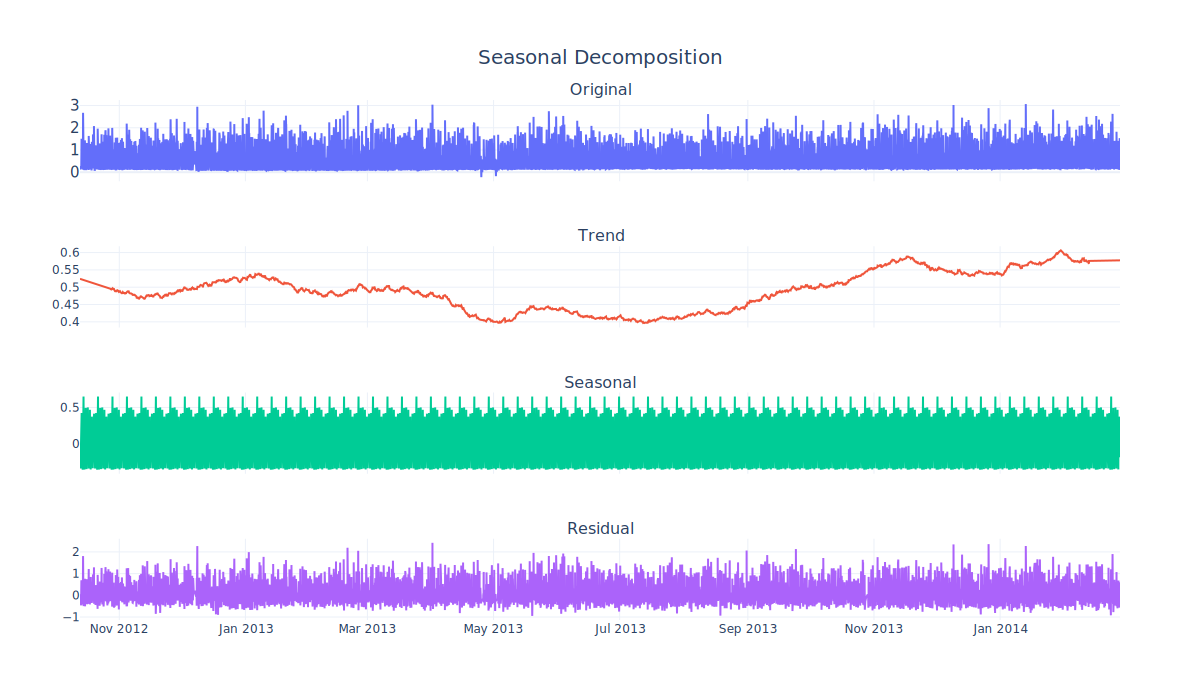

In [17]:
fig = decomposition_plot(ts_df.index, res.observed, res.seasonal, res.trend, res.resid)
fig.write_image("imgs/chapter_3/moving_avg_decomposition.png")
fig.show(renderer="svg")

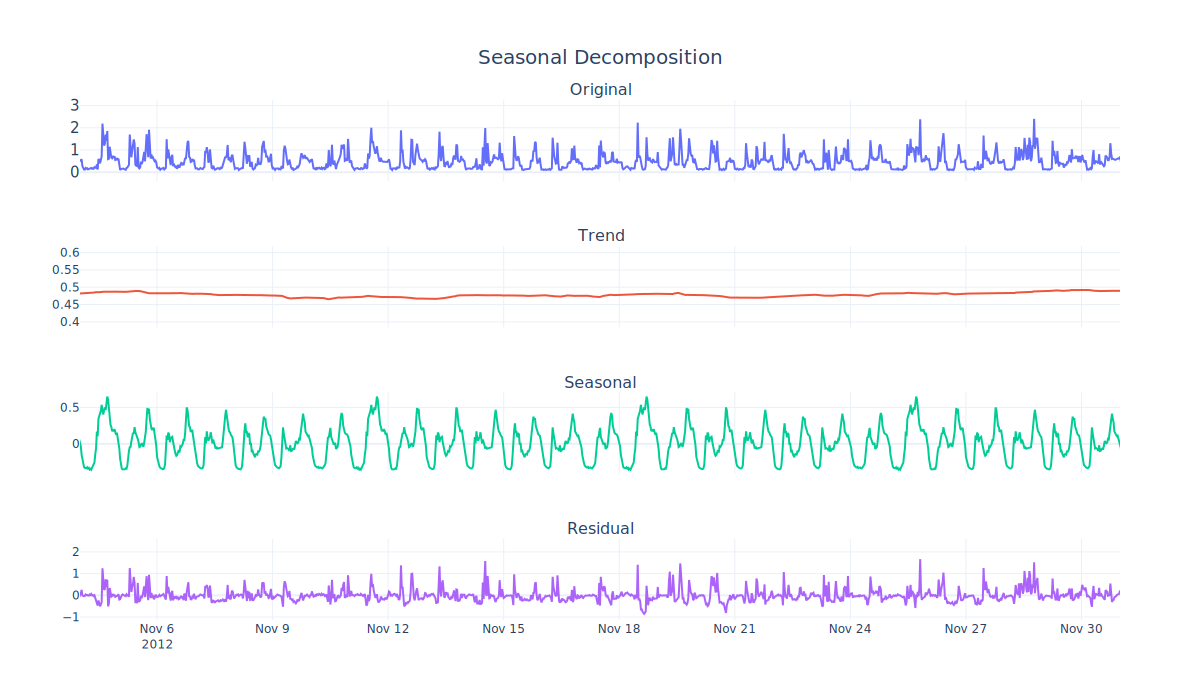

In [18]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-1"])
fig.write_image("imgs/chapter_3/moving_avg_decomposition_zoomed.png")
fig.show(renderer="svg")

-----

# Seasonality and Trend Decomposition using Loess (STL)


In [19]:
#Supports missing values and expects a series or dataframe with datetime index
stl = STL(seasonality_period=7*48, model = "additive")
res_new = stl.fit(ts_df.energy_consumption)

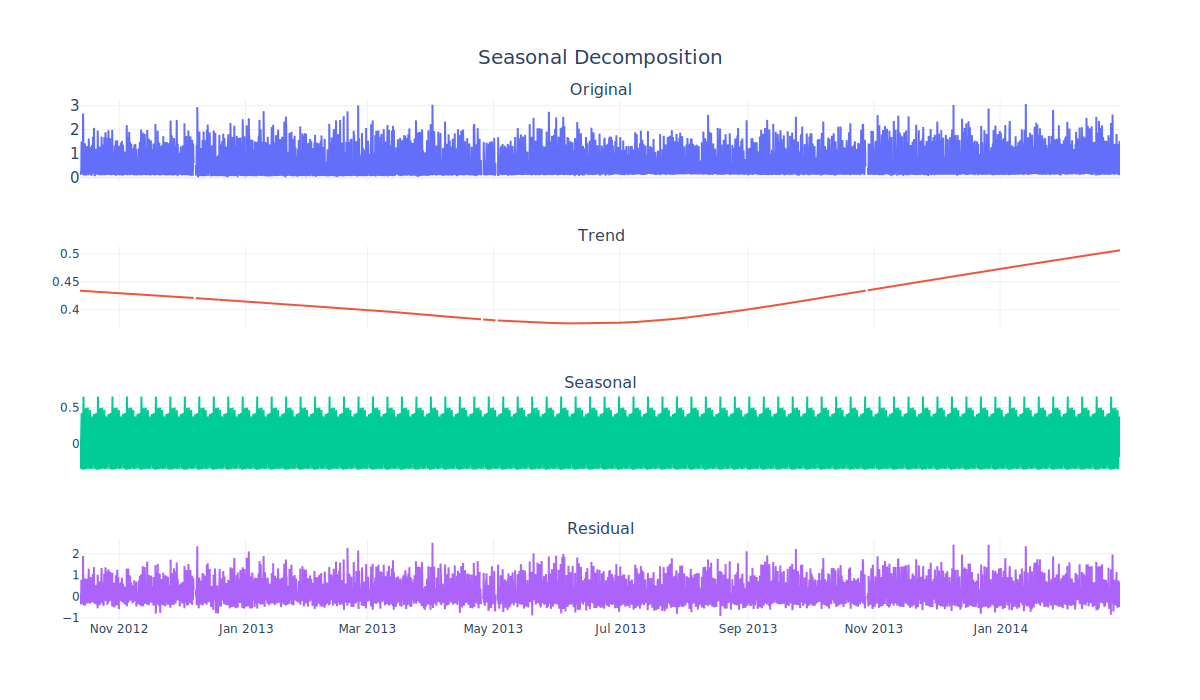

In [20]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_3/stl_decomposition.png")
fig.show(renderer="svg")

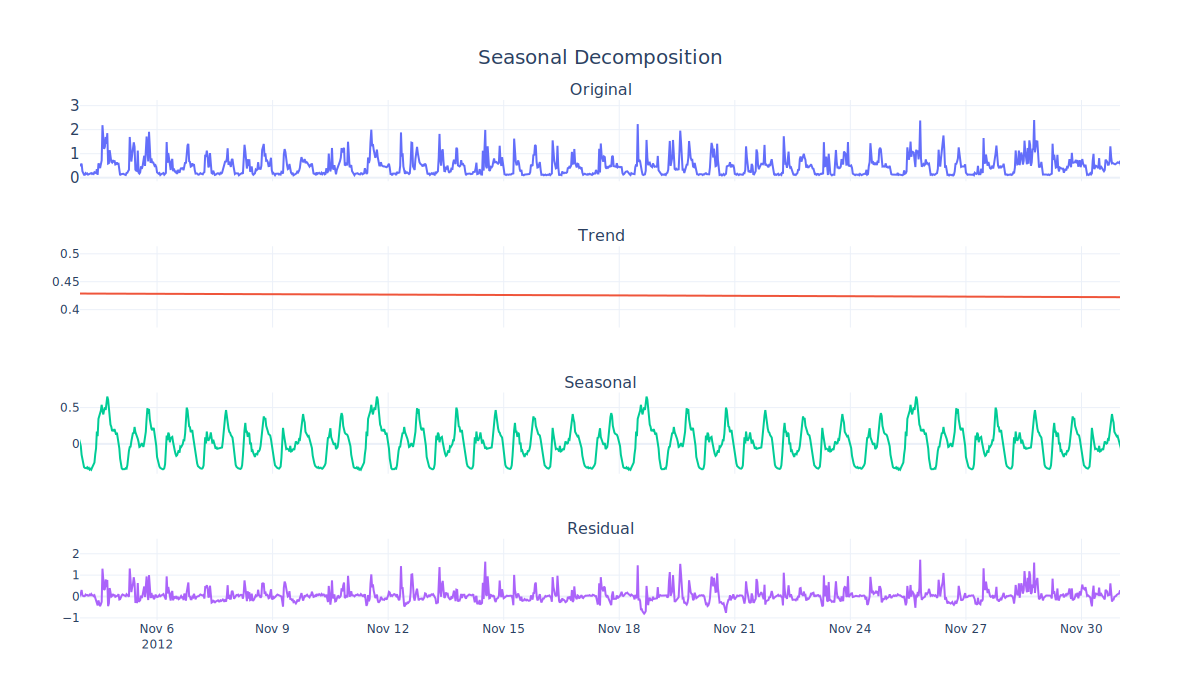

In [21]:
#Let's zoom in on a few days to better see the seasonality extracted
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-1"])
fig.write_image("imgs/chapter_3/moving_avg_decomposition_zoomed.png")
fig.show(renderer="svg")

# Seasonality and Trend Decomposition using Loess and Fourier Terms (Fourier Decomposition)

In [22]:
#Doesn't support missing values, and expects a series or datafeame with datetime index
stl = FourierDecomposition(seasonality_period="hour", model = "additive", n_fourier_terms=5)
res_new = stl.fit(pd.Series(ts.squeeze(), index=ts_df.index))

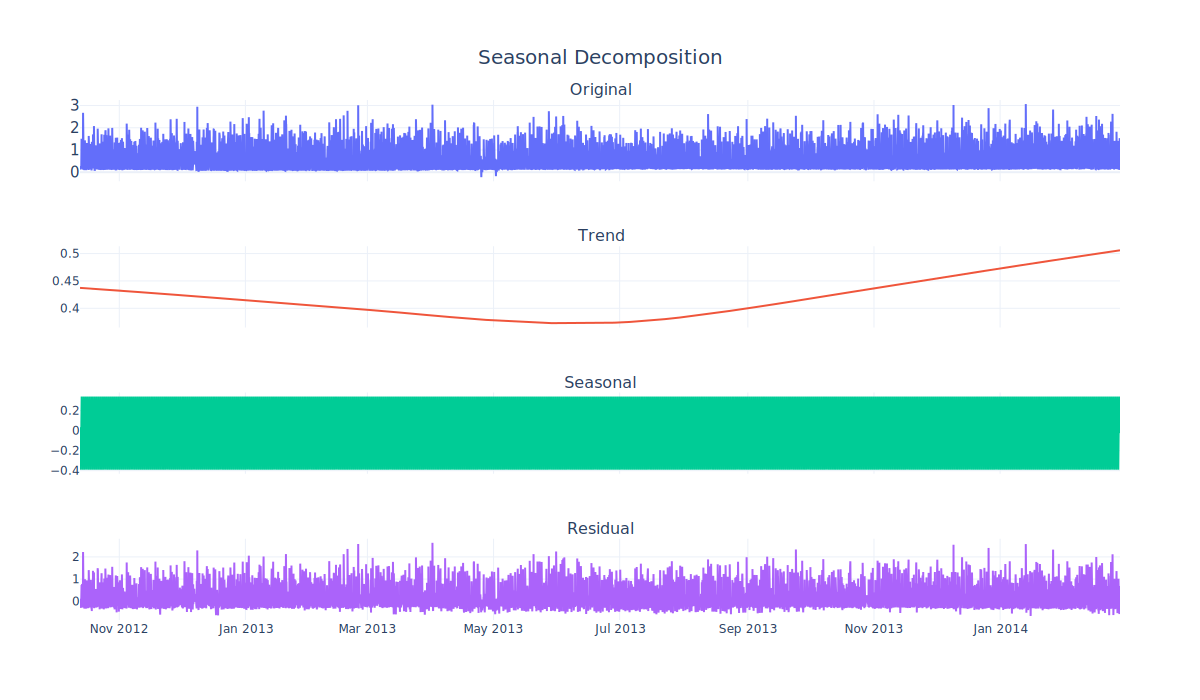

In [23]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_3/fourier_decomposition_hourly.png")
fig.show(renderer="svg")

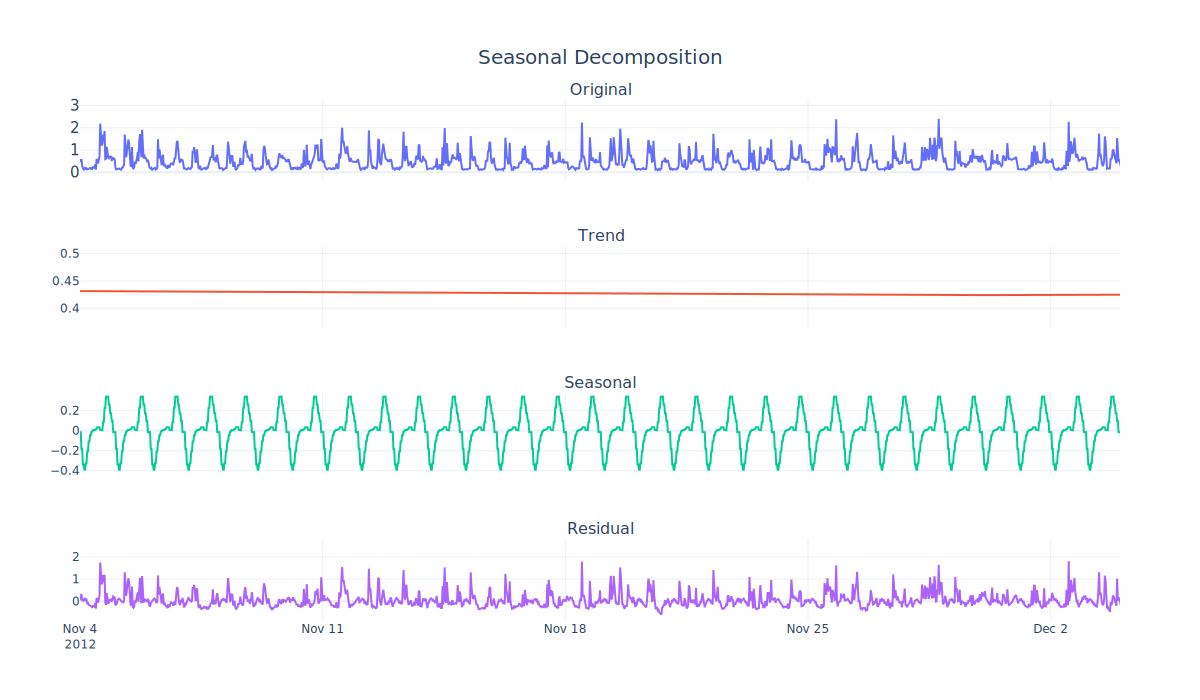

In [24]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_3/fourier_decomposition_hourly_zoomed.png")
fig.show(renderer="svg")

### Custom Seasonality

In [25]:
#Making a custom seasonality term
ts_df["dayofweek"] = ts_df.index.dayofweek
ts_df["hour"] = ts_df.index.hour
#Creating a sorted unique combination df
map_df = ts_df[["dayofweek","hour"]].drop_duplicates().sort_values(["dayofweek", "hour"])
# Assigning an ordinal variable to capture the order
map_df["map"] = np.arange(1, len(map_df)+1)
# mapping the oprdinal mapping back to the original df and getting the seasonality array
seasonality = ts_df.merge(map_df, on=["dayofweek","hour"], how='left', validate="many_to_one")['map']


In [32]:
ts_df[["dayofweek","hour"]].drop_duplicates().sort_values(["dayofweek", "hour"])

,dayofweek,hour
timestamp,,
2012-10-15 00:00:00,0,0
2012-10-15 01:00:00,0,1
2012-10-15 02:00:00,0,2
2012-10-15 03:00:00,0,3
2012-10-15 04:00:00,0,4
...,...,...
2012-10-14 19:00:00,6,19
2012-10-14 20:00:00,6,20
2012-10-14 21:00:00,6,21


In [33]:
stl = FourierDecomposition(model = "additive", n_fourier_terms=50)
res_new = stl.fit(pd.Series(ts, index=ts_df.index), seasonality=seasonality)

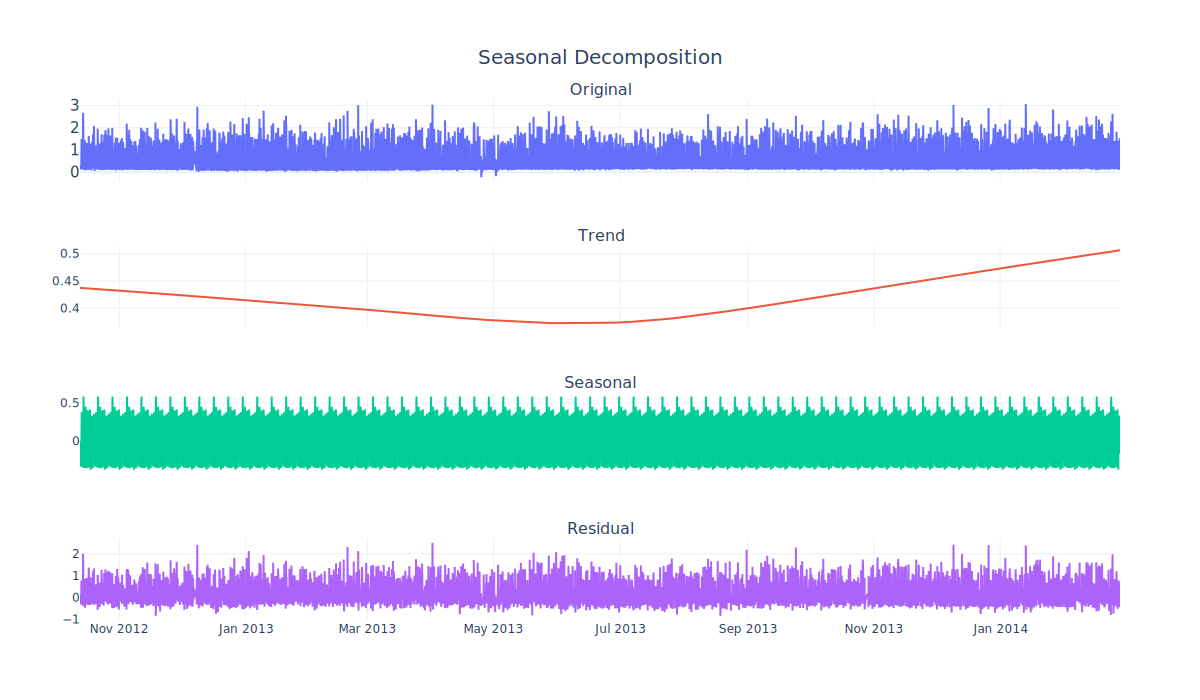

In [34]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_3/fourier_decomposition.png")
fig.show(renderer="svg")

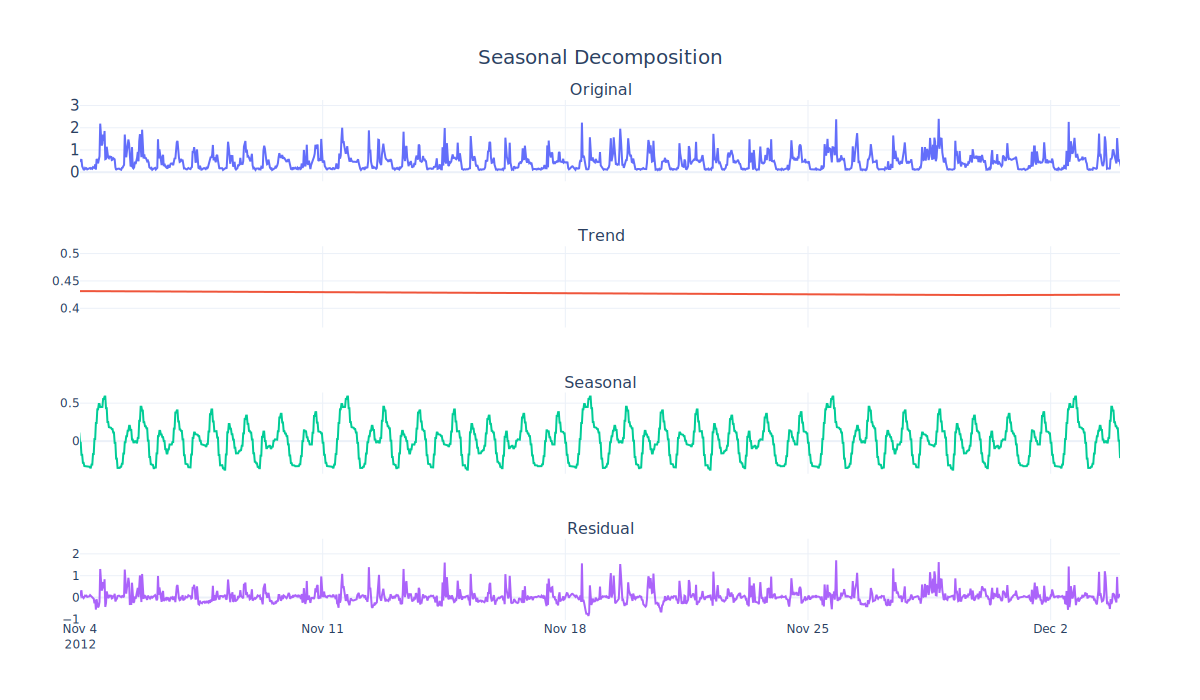

In [35]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_3/fourier_decomposition_zoomed.png")
fig.show(renderer="svg")

In [36]:
stl = MultiSeasonalDecomposition(seasonal_model="fourier",seasonality_periods=["day_of_year", "day_of_week", "hour"], model = "additive", n_fourier_terms=10)
res_new = stl.fit(pd.Series(ts, index=ts_df.index))

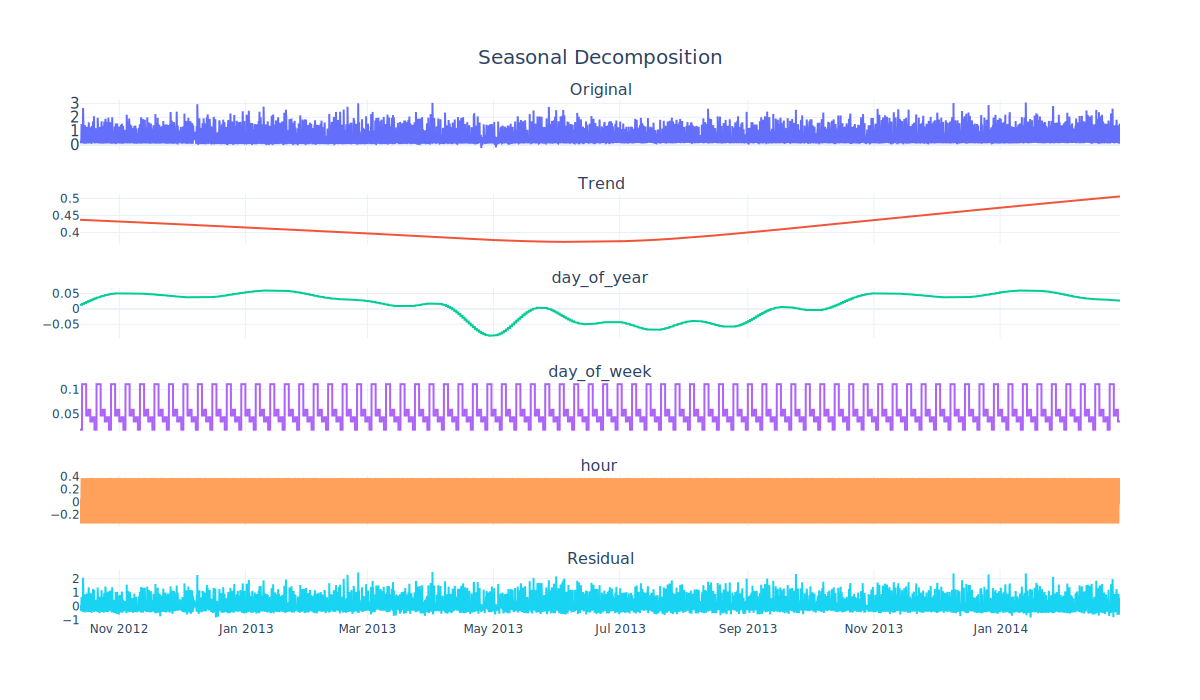

In [37]:
fig = res_new.plot(interactive=True)
fig.update_layout(
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
fig.write_image("imgs/chapter_3/mstl_decomposition_fourier.png")
fig.show(renderer="svg")

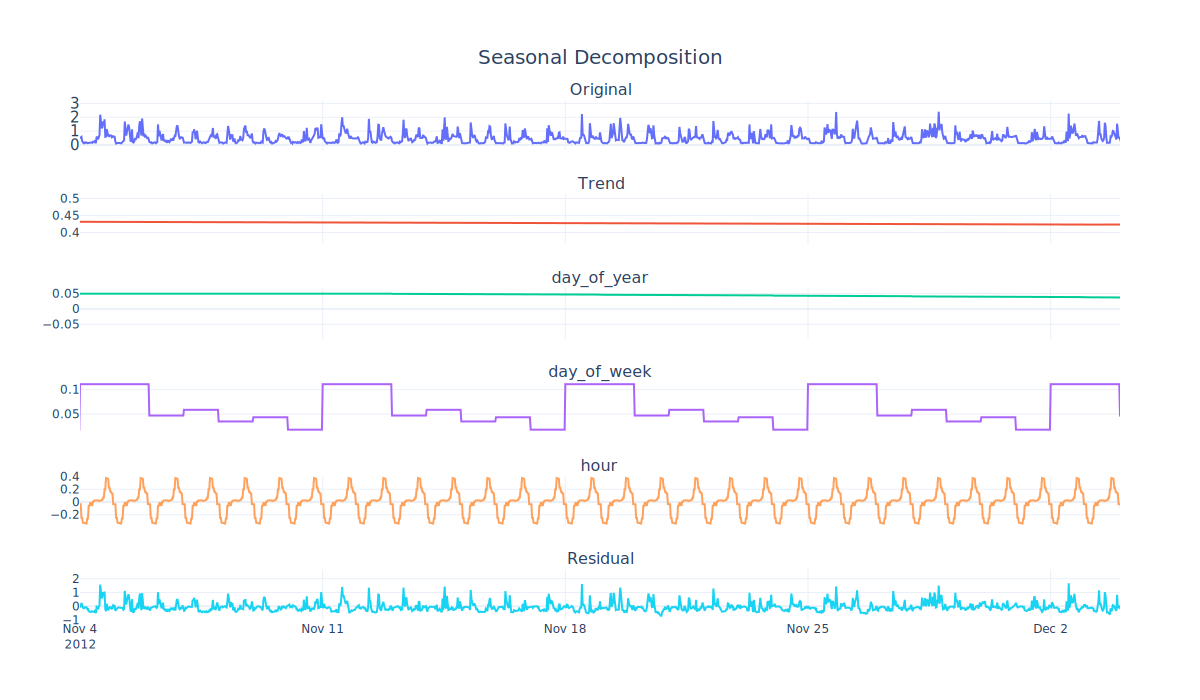

In [38]:
fig.update_xaxes(type="date", range=["2012-11-4", "2012-12-4"])
fig.write_image("imgs/chapter_3/mstl_decomposition_fourier_zoomed.png")
fig.show(renderer="svg")